<div style="text-align: center; font-family: 'Arial', sans-serif;">
    <h1 style="color: #2c3e50;">Security and Privacy in Machine Learning</h1>
    <h3 style="color: #34495e;">Course Code: 40816</h3>
    <h3 style="color: #7f8c8d;">Instructor: Dr. Amir Mahdi Sadeghzadeh</h3>
    <h3 style="color: #95a5a6;">Sharif University of Technology, Iran</h3>
    <h3 style="color: #bdc3c7;">CE Department, Fall 2024</h3>
    <h3 style="color: #d35400;">Computer Assignment 5</h3>
    <h4 style="color: #e67e22;">Topic: Differential Privacy</h4>
</div>


<div style="text-align: left; font-family: 'Arial', sans-serif; font-size: 14px;">
    <h2 style="color: #3498db;">Introduction</h2>
    <p>This notebook contains the implementation for Computer Assignment 5 on Differential Privacy. Follow the instructions carefully and ensure your code adheres to the provided guidelines.</p>
</div>


<div style="text-align: left; font-family: 'Arial', sans-serif; font-size: 14px;">
    <h2 style="color: #9b59b6;">Personal Data</h2>
    <p>Please enter your student number, first name, and last name in the following cell.</p>
</div>

In [1]:
# Enter your personal details below
student_number = "402203389"  # Replace with your student number
first_name = "Fateme"      # Replace with your first name
last_name = "Raeijian"       # Replace with your last name

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h1 style="color: #2c3e50;">Part 0: Introduction to Differential Privacy</h1>
</div>

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #34495e;">Question 0: Differential Privacy Definitions (5 Points)</h2>
</div> 

Provide a brief summary of Differential Privacy principles. Define $\epsilon$-differential privacy and explain its significance in protecting individual data privacy.


Differential Privacy (DP) is a mathematical framework designed to provide strong privacy guarantees when analyzing and sharing information about a dataset containing personal data. The central idea is that the output of a data analysis mechanism should not depend significantly on any single individual’s data. This ensures that an adversary cannot infer much about any specific individual’s data from the published results.

A mechanism $ \mathcal{M} $ is said to be $\epsilon$-differentially private if, for all pairs of neighboring datasets $ D $ and $ D' $ (which differ by just one individual’s data), and for all possible outcomes $ S $ of the mechanism, the following holds:

$$
\Pr[\mathcal{M}(D) \in S] \leq e^\epsilon \cdot \Pr[\mathcal{M}(D') \in S]
$$

Here,
- $ \epsilon $ (epsilon) is a non-negative parameter that controls the privacy loss: smaller values of $ \epsilon $ imply stronger privacy.
- The probabilities are taken over the randomness in the mechanism $ \mathcal{M} $.

**Significance:**
- **Privacy Guarantee:** The definition ensures that the probability of any output does not change much with or without any single individual’s data. Thus, the presence or absence of one individual is not easily detectable.
- **Controlled Leakage:** $ \epsilon $ quantifies the maximum amount by which an individual’s data can influence the output, offering a clear way to trade off between privacy and accuracy.
- **Robustness:** Differential privacy is immune to side information: even if an adversary has extra information, the privacy guarantee still holds.

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h1 style="color: #2c3e50;">Part 1: Mechanisms for Differential Privacy</h1>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml # need sklearn >= 0.22
import scipy as sp
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelBinarizer

Below we provide a helper function to draw bar plots from pandas Series.

In [13]:
def bar_plot_pandas(series1, series2=None, label1="Series 1", label2="Series 2", title=""):
    '''
    Draws a bar plot of one Pandas Series, or two pandas Series with the same index
    
    Parameters
    ----------
    series1 : Series of float
        First input
    series2 : Series of float, optional
        Second input (with same index)
    label1 : string, optional
        Label for the first series
    label2 : string, optional
        Label for the second series
    title : string, optional
        Plot title
    '''
    if series2 is None:
        series1.plot.bar()
        plt.xlabel("Index")
        plt.ylabel("Values")
        plt.title(title if title else "Bar Plot")
        plt.legend([label1])
        plt.show()
    else:
        # Create a DataFrame directly from the two series, aligning by index
        df = pd.DataFrame({label1: series1, label2: series2})
        df.plot.bar()
        plt.xlabel("Index")
        plt.ylabel("Values")
        plt.title(title if title else "Comparison Bar Plot")
        plt.legend()
        plt.show()

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Dataset</h2>
</div>

We will be working with a dataset from the US Census (also known as the Adult dataset). You can read about the dataset [here](https://archive.ics.uci.edu/ml/datasets/census+income).

The following line loads the dataset from [OpenML](https://www.openml.org/) with the `fetch_openml` method of `sklearn`. The option `as_frame=True` (**requires sklearn version >= 0.22**) loads the dataset in `pandas DataFrame` format: this keeps the attributes in their original form and will be more convenient to work with. If you prefer working with a numpy array (not recommended), set `as_frame=False`.

In [5]:
# Fetching the Adult dataset from OpenML
dataset_handle = fetch_openml(name='adult', version=2, as_frame=True)
dataset = dataset_handle.frame

Take a look at the dataset, in particular the number of rows (individuals), the number of columns (attributes) and what they represent.

In [6]:
# Exploring the dataset
n, d = dataset.shape  # Number of rows and columns
print(f"Dataset contains {n} rows (individuals) and {d} columns (attributes).")
print("\nPreview of the dataset:")
print(dataset.head(4))

Dataset contains 48842 rows (individuals) and 15 columns (attributes).

Preview of the dataset:
   age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   

          occupation relationship   race   sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black  Male             0             0   
1    Farming-fishing      Husband  White  Male             0             0   
2    Protective-serv      Husband  White  Male             0             0   
3  Machine-op-inspct      Husband  Black  Male          7688             0   

   hours-per-week native-country  class  
0              40  United-States  <=50K  
1              50  United-States  <=50

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 1 (non-private queries) (7 Points)</h2>
</div>

Implement a function for each of these types of queries (without privacy) and test them on the dataset:
- **Simple count queries**: it takes as input a dataset (`DataFrame`), a categorical attribute (e.g., `"sex"`) and a value (e.g., `"Male"`), and returns how many rows in the dataset have the prescribed attribute value.
- **Averaging queries**: it takes as input a dataset and a numeric attribute (e.g., `"age"`), and returns the average value of this attribute in the dataset.
- **Histogram queries**: it takes as input a dataset and a categorical attribute (e.g., `"sex"`), and returns the histogram of counts for this attribute in the dataset (i.e., for each possible value of the attribute, how many rows have this value).

Reminder: for a DataFrame `df`, we can access the column corresponding to an attribute `attr` by `df[attr]`. The method `value_counts()` allows to build a histogram of a column. To plot a pandas Series `s` as a histogram, you can use `s.plot.bar()`.

Note: You can use the function `bar_plot_pandas` provided in the preamble to draw a bar plot of a pandas Series, which is useful to show histograms.

In [7]:
def count_query(df, attribute, value):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values
    value : string or int
        Value of attribute to count
        
    Returns
    -------
    count : int
        The number of records with `attribute=value` in dataset `df`
    '''
    # Count the number of rows where df[attribute] equals the specified value
    return (df[attribute] == value).sum()

In [8]:
def average_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with numeric values
        
    Returns
    -------
    average : float
        The average value of `attribute` in dataset `df`
    '''
    # Compute the mean of the specified numeric column
    return df[attribute].mean()

In [10]:
def histogram_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values
        
    Returns
    -------
    histogram : array or Series of int
        The histogram of `attribute`, i.e., the number of times each value of `attribute` appears in `df`
    '''
    # Use value_counts to get frequency of each categorical value in the column
    return df[attribute].value_counts()

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 2 (Laplace mechanism) (10 Points)</h2>
</div>

Implement the Laplace mechanism, i.e., a function which takes as input a (non-private) query output, the query's $\ell_1$ sensitivity, the desired value of $\epsilon$ and a random seed (for reproducibility), and returns a $\epsilon$-differentially private estimate of the query. To draw Laplace noise, check `np.random.laplace`. The function should work with queries that output a scalar (like simple count and averaging queries), as well as those that output a vector (like histogram queries).

In [11]:
def laplace_mechanism(q, s1, eps, random_state=None):
    '''
    Parameters
    ----------
    q : float or array/Series of float
        The non-private output of the query
    s1 : float
        The L1 sensitivity of the query
    eps : float
        Parameter epsilon of differential privacy
    random_state : int, optional (default=None)
        Random seed
        
    Returns
    -------
    private_q : float or array/Series of float
        An eps-DP evaluation of the query
    '''
    rng = np.random.RandomState(random_state)
    
    # Determine the scale for Laplace noise
    scale = s1 / eps
    
    if hasattr(q, 'shape'):  # query output is multi-dimensional (e.g., array or Series)
        # Create noise with the same shape as q
        noise = rng.laplace(loc=0.0, scale=scale, size=q.shape)
        
        # Add noise to the original query output
        private_q = q + noise
        
        # If q is a pandas Series, ensure the result retains the same index
        if isinstance(q, pd.Series):
            private_q = pd.Series(private_q, index=q.index)
    else:  # query output is a scalar
        noise = rng.laplace(loc=0.0, scale=scale)
        private_q = q + noise
        
    return private_q

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 3 (Laplace mechanism on count queries) (8 Points)</h2>
</div>

We would like to use the Laplace mechanism to:
- privately count the number of males in the dataset
- generate a private histogram of the `"workclass"` attribute

What is the sensitivity of the query in each case?

Run the Laplace mechanism with different values of $\epsilon$ and compute the $\ell_1$-error with respect to the true (non-private) output to see the effect on the utility and compare with the formal error bound seen in the lecture. Recall that the mechanism is random, so unless you fix the seed you will get a different result at each execution. Visually compare the private and non-private histograms using the function `bar_plot_pandas` provided at the beginning of the notebook.

Note: you may round the outputs of the private mechanism to make them integers if you like. This can be considered as post-processing and thus preserves DP (see Bonus Question 5 to go further on this aspect).


--- Results for ε = 0.1 ---

Count for ε = 0.1:
True count: 32650, Private count: 32647.110908252256, L1 error: 2.889091747743805

Histogram for ε = 0.1:
True histogram:
 workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64
Private histogram (rounded):
 workclass
Private             33903.0
Self-emp-not-inc     3885.0
Local-gov            3142.0
State-gov            1983.0
Self-emp-inc         1683.0
Federal-gov          1420.0
Without-pay            -1.0
Never-worked           23.0
Name: count, dtype: float64
L1 error: 92.49505358249019


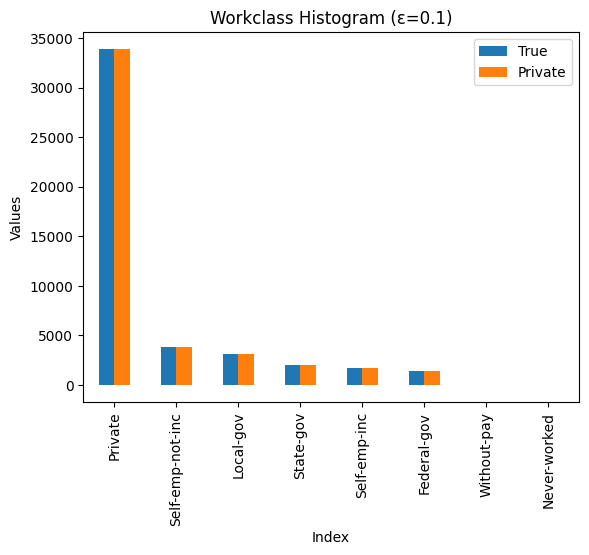


--- Results for ε = 1.0 ---

Count for ε = 1.0:
True count: 32650, Private count: 32649.711090825225, L1 error: 0.2889091747747443

Histogram for ε = 1.0:
True histogram:
 workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64
Private histogram (rounded):
 workclass
Private             33906.0
Self-emp-not-inc     3864.0
Local-gov            3137.0
State-gov            1981.0
Self-emp-inc         1694.0
Federal-gov          1431.0
Without-pay            19.0
Never-worked           11.0
Name: count, dtype: float64
L1 error: 9.249505358245994


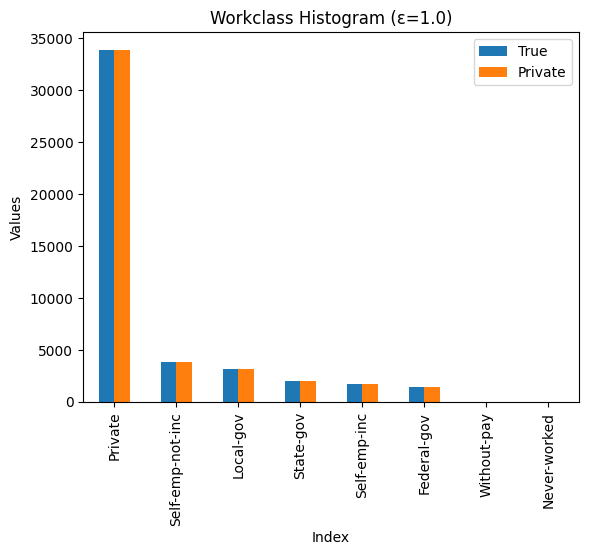

In [14]:
def l1_error(a, b):
    '''
    Parameters
    ----------
    a : float or array/Series of float
        First input
    b : float or array/Series of float
        Second input
        
    Returns
    -------
    l1_error : float
        The L1 distance between `a` and `b`: ||a-b||_1
    '''
    a_arr = np.asarray(a)
    b_arr = np.asarray(b)
    return np.sum(np.abs(a_arr - b_arr))

# Define the queries with their sensitivities
queries = [
    # Query for counting number of males
    (lambda df: count_query(df, "sex", "Male"), 1),
    
    # Query for histogram of "workclass"
    (lambda df: histogram_query(df, "workclass"), 1)
]

for eps in [0.1, 1.0]:
    print(f"\n--- Results for ε = {eps} ---")
    for query_func, sensitivity in queries:
        true_result = query_func(dataset)
        private_result = laplace_mechanism(true_result, sensitivity, eps, random_state=42)
        
        error_value = l1_error(private_result, true_result)
        
        if isinstance(true_result, pd.Series):
            print(f"\nHistogram for ε = {eps}:")
            print("True histogram:\n", true_result)
            print("Private histogram (rounded):\n", private_result.round())
            print(f"L1 error: {error_value}")
            bar_plot_pandas(true_result, private_result.round(), 
                            label1="True", label2="Private", 
                            title=f"Workclass Histogram (ε={eps})")
        else:
            print(f"\nCount for ε = {eps}:")
            print(f"True count: {true_result}, Private count: {private_result}, L1 error: {error_value}")

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 4 (Gaussian mechanism and comparison with Laplace) (12 Points)</h2>
</div>

Implement the Gaussian mechanism (to draw Gaussian noise, check `np.random.normal`). Make an experimental comparison with the Laplace mechanism by plotting the privacy-utility trade-off for a 1D query of your choice. For the Gaussian mechanism, study the influence of $\delta$.

In [15]:
def gaussian_mechanism(q, s2, eps, delta, random_state=None):
    '''
    Parameters
    ----------
    q : float or array/Series of float
        The non-private output of the query
    s2 : float
        The L2 sensitivity of the query
    eps : float
        Parameter epsilon of differential privacy
    delta : float
        Parameter delta of differential privacy
    random_state : int, optional (default=None)
        Random seed
        
    Returns
    -------
    private_q : float or array/Series of float
        An (eps,delta)-DP evaluation of the query
    '''
    
    rng = np.random.RandomState(random_state)
    
    # Calculate the standard deviation for the Gaussian noise
    sigma = (s2 * np.sqrt(2 * np.log(1.25 / delta))) / eps
    
    if hasattr(q, 'shape'):  # query output is multi-dimensional
        noise = rng.normal(loc=0.0, scale=sigma, size=q.shape)
        private_q = q + noise
        # If q is a pandas Series, maintain the index
        if isinstance(q, pd.Series):
            private_q = pd.Series(private_q, index=q.index)
    else:  # query output is a scalar
        noise = rng.normal(loc=0.0, scale=sigma)
        private_q = q + noise
        
    return private_q

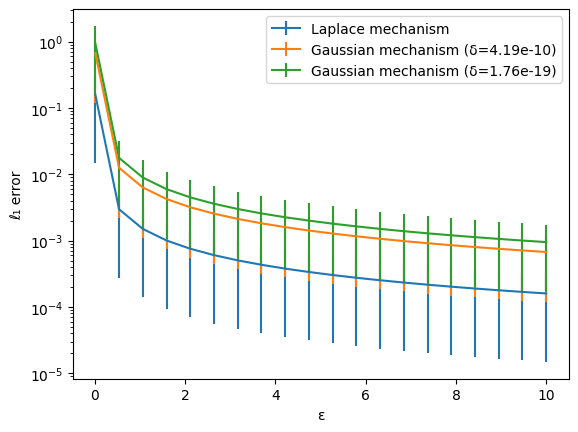

In [16]:
# Define the 1D query: average age
q_value = average_query(dataset, "age")

# Sensitivities for the average query
# For a count query, sensitivity (s1) was 1 because a change in one individual's presence changes the sum by at most the maximum value.
# For the average query over n individuals, sensitivity = (max - min) / n.
s1 = (dataset["age"].max() - dataset["age"].min()) / len(dataset)

# For Gaussian mechanism, we need an L2 sensitivity (s2).
# For a 1D output like the average, the L2 sensitivity can be considered the same as the L1 sensitivity.
s2 = s1

eps_list = np.linspace(0.01, 10.0, num=20)
delta1 = 1. / len(dataset)**2
delta2 = 1. / len(dataset)**4
n_runs = 50

error = np.zeros((len(eps_list), 3, n_runs))

for i, eps in enumerate(eps_list):
    for r in range(n_runs):
        # Laplace mechanism error
        lap_result = laplace_mechanism(q_value, s1, eps, random_state=r)
        error[i, 0, r] = l1_error(lap_result, q_value)
        
        # Gaussian mechanism error for delta1
        gauss1 = gaussian_mechanism(q_value, s2, eps, delta1, random_state=r)
        error[i, 1, r] = l1_error(gauss1, q_value)
        
        # Gaussian mechanism error for delta2
        gauss2 = gaussian_mechanism(q_value, s2, eps, delta2, random_state=r)
        error[i, 2, r] = l1_error(gauss2, q_value)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(eps_list, error[:, 0, :].mean(axis=1), yerr=error[:, 0, :].std(axis=1), 
            label='Laplace mechanism')
ax.errorbar(eps_list, error[:, 1, :].mean(axis=1), yerr=error[:, 1, :].std(axis=1),
            label='Gaussian mechanism (δ=' + "{:.2e}".format(delta1) + ')')
ax.errorbar(eps_list, error[:, 2, :].mean(axis=1), yerr=error[:, 2, :].std(axis=1),
            label='Gaussian mechanism (δ=' + "{:.2e}".format(delta2) + ')')
plt.xlabel("ε")
plt.ylabel("ℓ₁ error")
ax.set_yscale('log')
ax.legend()
plt.show()

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h1 style="color: #2c3e50;">Part 3: Applications of Differential Privacy</h1>
</div>

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 5 (contingency tables and the "paradox" of parallel composition) (8 Points)</h2>
</div>

We can go beyond histograms and build contingency tables across two (or even more) variables. Implement a function for such queries using `crosstab` from pandas, and use the Laplace mechanism to privately find out how people in the dataset break down according to the combination of `'gender'` and `'marital-status'`. You may need to adapt your implementation of Laplace to work with k-way tables (e.g., by using the method `applymap` together with a function that adds 1D Laplace noise).

Pushing this reasoning further, it may seem that there is a paradox because parallel composition gets us more information "for free" (e.g., we can build a k-way table over a large number of attributes that could ultimately reveal very precise information about individuals in the dataset, without increasing the privacy loss). This contradicts the principle that asking more things should cost something. Explain why there is in fact no paradox and what is the cost that one pays in this case (if needed, you can see what happens when privately releasing contingency tables across many columns).

In [17]:
def table_query(df, row_attr_list, col_attr_list):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    row_attr_list : list
        List of attributes to use as rows
    col_attr_list : list
        List of attributes to use as columns
        
    Returns
    -------
    cross_table : DataFrame
        Cross tabulation (contingency table) of `df` according to `row_attr_list` and `col_attr_list`
    '''
    # Use pandas.crosstab to compute the contingency table
    cross_table = pd.crosstab(index=[df[attr] for attr in row_attr_list],
                              columns=[df[attr] for attr in col_attr_list])
    return cross_table

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 6 (Laplace mechanism on average queries) (9 Points)</h2>
</div>

We would like to use the Laplace mechanism to privately estimate the average age of people in the dataset. We assume that the number of people in the dataset is public.

1. Propose and implement simple practical strategies to compute or estimate the sensitivity of this query in the following two scenarios, and discuss the merits and/or drawbacks of your proposals:
  - You are the trusted curator: you have access to the raw dataset and would like to release an estimate of the average age of people in the dataset with differential privacy guarantees.
  - You are an external data analyst: you do not have access to the raw dataset but only to an API to send queries. You have to convince the trusted curator that the proposed sensitivity is safe.
2. Suggest some ideas regarding how we could change a bit the query to get a simple and safe bound on sensitivity, at the expense of possibly introducing some bias in the output. Implement the proposed solution. Hint: the method `clip` from pandas might be useful here.

### 1. Strategies to Compute or Estimate Sensitivity
### a) Trusted Curator Scenario

**Proposal:**
- As a trusted curator with full dataset access, you know the exact ages of individuals.
- **Sensitivity Calculation:**
  
  Given the dataset size \( n \) is public, the sensitivity of the average age query can be computed as:

  $$
  s = \frac{\max(\text{age}) - \min(\text{age})}{n}
  $$

  because adding or removing a single individual can change the sum of ages by at most \( \max(\text{age}) - \min(\text{age}) \), and the average is that change divided by \( n \).

**Merits:**
- Provides a tight sensitivity bound tailored to the actual data.
- Potentially lower sensitivity than using a conservative global bound.

**Drawbacks:**
- Requires access to sensitive raw data.
- Computed sensitivity may reveal information about the data range to some extent if not handled carefully.

---

### b) External Data Analyst Scenario

**Proposal:**
- Without direct access to the raw data, you must rely on known or assumed bounds for the “age” attribute.
- **Safe Sensitivity Bound:**

  Use a conservative age range (e.g., 0 to 120 years). Then, assuming \( n \) is known:

  $$
  s = \frac{120 - 0}{n} = \frac{120}{n}
  $$

  This is a safe upper bound on sensitivity, guaranteeing differential privacy regardless of the actual data values.

**Merits:**
- Does not require access to raw data.
- Guarantees safety by using worst-case bounds.

**Drawbacks:**
- Likely overestimates sensitivity, especially if the true age range is much narrower.
- Results in adding more noise than necessary, reducing utility.

### 2. Modifying the Query for a Safe Sensitivity Bound

**Idea:**
To obtain a simple and safe sensitivity bound, clip the age values to a predetermined range \([L, U]\) before computing the average. This restricts the influence of any single data point.

- **Clipping Ages:**
  
  Use `clip` from pandas to limit ages to \([L, U]\).

- **Sensitivity with Clipping:**

  Once all ages are within \([L, U]\), the maximum change due to a single individual is bounded by \( U - L \). The sensitivity of the average then becomes:

  $$
  s = \frac{U - L}{n}
  $$

  This bound is safe and simple.

**Merits:**
- Provides a known, fixed sensitivity.
- Limits the effect of outliers on the average.
- Results in a bounded and stable sensitivity value.

**Drawbacks:**
- Introduces bias if true ages fall outside the \([L, U]\) range.
- The average may no longer reflect the true mean if many values are clipped.

In [18]:
def private_average_age_with_clipping(df, attribute="age", lower_bound=0, upper_bound=100, eps=1.0, random_state=None):
    """
    Computes a differentially private average of an attribute after clipping its values.

    Parameters
    ----------
    df : DataFrame
        The dataset containing the attribute.
    attribute : string
        The name of the numeric attribute to average.
    lower_bound : float
        The lower bound to clip the attribute values.
    upper_bound : float
        The upper bound to clip the attribute values.
    eps : float
        Differential privacy parameter epsilon.
    random_state : int, optional
        Random seed for reproducibility.
        
    Returns
    -------
    private_avg : float
        The differentially private average of the clipped attribute.
    """
    # Clip the attribute values between lower_bound and upper_bound
    clipped_values = df[attribute].clip(lower=lower_bound, upper=upper_bound)
    
    # Compute the average of the clipped values
    avg_value = clipped_values.mean()
    
    # Number of individuals in the dataset
    n = len(clipped_values)
    
    # Sensitivity after clipping
    sensitivity = (upper_bound - lower_bound) / n
    
    # Apply Laplace mechanism to the average
    private_avg = laplace_mechanism(avg_value, sensitivity, eps, random_state=random_state)
    return private_avg

# Example usage:
eps = 1.0
private_avg_age = private_average_age_with_clipping(dataset, attribute="age", lower_bound=0, upper_bound=100, eps=eps, random_state=42)
print("Private average age:", private_avg_age)

Private average age: 38.642993920857506


<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 7 (average over a subset) (6 Points)</h2>
</div>

We would now like to compute the average age of divorced people. How can we use the Laplace mechanism to privately answer this query? Implement your solution.

### Computing the Average Age of Divorced People Privately

To privately compute the average age of divorced people, we can follow a similar approach to computing the overall average age but restrict our attention to the subset of individuals who are divorced. The steps are:

1. Filter the dataset to include only divorced individuals.
2. Compute the average age for this subset.
3. Estimate sensitivity for this query.
4. Apply the Laplace mechanism to the computed average.

---

### Considerations for Sensitivity:

- The sensitivity calculation for an average over a subset (e.g., divorced individuals) is similar to the full dataset case, but now the dataset size \( n_{\text{div}} \) refers to the number of divorced individuals.
- Assuming ages are bounded within \([L, U]\) (using clipping as in Question 6), the sensitivity for the average of divorced people is:

  $$
  s = \frac{U - L}{n_{\text{div}}}
  $$

  where \( n_{\text{div}} \) is the number of divorced individuals.

- We assume that \( n_{\text{div}} \) can be computed or approximated (often as part of the query process or assumed public knowledge). If \( n_{\text{div}} \) is not publicly known, additional private mechanisms would be needed to estimate it, but for simplicity, we assume it’s known.

### implementaion

In [19]:
def private_average_age_divorced(df, attribute="age", marital_status="Divorced",
                               lower_bound=0, upper_bound=100, eps=1.0, random_state=None):
    """
    Computes a differentially private average age for individuals with a specific marital status (e.g., Divorced)
    after clipping age values.
    
    Parameters
    ----------
    df : DataFrame
        The dataset containing the attributes.
    attribute : string
        The numeric attribute to average (e.g., "age").
    marital_status : string
        The marital status to filter on (e.g., "Divorced").
    lower_bound : float
        The lower bound to clip the age values.
    upper_bound : float
        The upper bound to clip the age values.
    eps : float
        Differential privacy parameter epsilon.
    random_state : int, optional
        Random seed for reproducibility.
        
    Returns
    -------
    private_avg : float
        The differentially private average age for the specified group.
    """
    # Filter the dataset for individuals with the specified marital status
    subset = df[df["marital-status"] == marital_status]
    
    # Clip the age values in the subset between lower_bound and upper_bound
    clipped_values = subset[attribute].clip(lower=lower_bound, upper=upper_bound)
    
    # Compute the average of the clipped ages
    avg_value = clipped_values.mean()
    
    # Number of individuals in the subset
    n_divorced = len(clipped_values)
    if n_divorced == 0:
        raise ValueError(f"No individuals found with marital status {marital_status}.")
    
    # Sensitivity for the average over the subset
    sensitivity = (upper_bound - lower_bound) / n_divorced
    
    # Apply Laplace mechanism to the average
    private_avg = laplace_mechanism(avg_value, sensitivity, eps, random_state=random_state)
    return private_avg

# Example usage:
eps = 1.0
private_avg_divorced_age = private_average_age_divorced(dataset, attribute="age",
                                                        marital_status="Divorced",
                                                        lower_bound=0, upper_bound=100,
                                                        eps=eps, random_state=42)
print("Private average age of divorced people:", private_avg_divorced_age)

Private average age of divorced people: 43.154848346528354


<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 8 (non-private SGD) (17 Points)</h2>
</div>

In this question, we will implement our own simple version of SGD, as well as define our own sklearn-compatible $\ell_2$-regularized logistic regression estimator. This will be convenient when we will implement a differentially private version in Question 9.

Below, you are given several pieces of code:
1. A function `sgd` which implements SGD: it is meant to be generic in the sense that it takes as input a function `obj_and_grad` which computes the value and the gradient of the desired objective function. **This function has missing parts that you need to complete**.


2. A function `my_logistic_obj_and_grad` (adapted from [the version from sklearn](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/linear_model/_logistic.py#L84)) which computes the value and gradient of the logistic regression problem. You do not need to modify this function.


3. A class `MySGDLogisticRegression` which defines a sklearn estimator for logistic regression, where the model is fit using SGD using the previous two functions. You do not need to modify this function.

Spend a bit of time to get familiar with the code provided, then complete the missing bits in the `sgd` function. Make sure it works by trying it on the binary classification dataset that you previously loaded.

In [21]:
def sgd(X, y, gamma, n_iter, obj_and_grad, theta_init, n_batch=1, freq_obj_eval=10,
        n_obj_eval=1000, random_state=None):
    """Stochastic Gradient Descent (SGD) algorithm

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    obj_and_grad : callable
        A function which takes as a vector of shape (p,), a dataset of shape (n_batch, d)
        and a label vector of shape (n_batch,), and returns the objective value and gradient.
    theta_init : array, shape (p,)
        The initial value for the model parameters
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objective
    random_state : int
        Random seed to make the algorithm deterministic


    Returns
    -------
    theta : array, shape=(p,)
        The final value of the model parameters
    obj_list : list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_obj_eval iterations
    """
    
    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]
    
    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma
    
    # list to record the evolution of the objective (for plotting)
    obj_list = []
    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        # Evaluate the objective on a fixed subset every freq_obj_eval iterations
        if t % freq_obj_eval == 0:
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)

        # 1. Sample a mini-batch of size n_batch
        idx_batch = rng.randint(0, n, n_batch)
        X_batch = X[idx_batch, :]
        y_batch = y[idx_batch]
        
        # 2. Compute gradient on the mini-batch
        _, grad = obj_and_grad(theta, X_batch, y_batch)
        
        # 3. Compute step size
        step_size = gamma_func(t)
        
        # 4. Gradient descent update
        theta -= step_size * grad
    
    return theta, obj_list

In [33]:
from sklearn.linear_model._base import LinearClassifierMixin, SparseCoefMixin, BaseEstimator
from sklearn.utils.extmath import safe_sparse_dot
from scipy.special import expit
from sklearn.utils.validation import check_X_y
from scipy.special import logsumexp

import numpy as np

def _intercept_dot(theta, X, y):
    """Compute the dot product of X with the weights and add the intercept if present.

    Parameters
    ----------
    theta : array, shape (d,) or (d+1,)
        The weights and optionally the intercept term.
    X : array, shape (n_samples, n_features)
        Feature matrix.
    y : array, shape (n_samples,)
        Labels (used for sign adjustment).

    Returns
    -------
    w : array, shape (n_features,)
        Weights without intercept.
    c : float
        Intercept term.
    yz : array, shape (n_samples,)
        Dot product of (X @ w + c) multiplied by y.
    """
    n_features = X.shape[1]
    w = theta[:n_features]  # Extract weights
    c = theta[n_features] if len(theta) > n_features else 0  # Extract intercept if present
    yz = y * (np.dot(X, w) + c)  # Compute yz as y * (X @ w + c)
    return w, c, yz

def log_logistic(z):
    return -logsumexp([np.zeros_like(z), -z], axis=0)

def my_logistic_obj_and_grad(theta, X, y, lamb):
    """Computes the value and gradient of the objective function of logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = w (if no intercept), or theta = [w b] (if intercept)

    Parameters
    ----------
    theta_init : array, shape (d,) or (d+1,)
        The initial value for the model parameters. When an intercept is used, it corresponds to the last entry
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1)
    lamb : float
        The L2 regularization parameter


    Returns
    -------
    obj : float
        The value of the objective function
    grad : array, shape (d,) or (d+1,)
        The gradient of the objective function
    """
    n_samples, n_features = X.shape
    grad = np.empty_like(theta)

    w, c, yz = _intercept_dot(theta, X, y)

    # Logistic loss is the negative of the log of the logistic function
    obj = -np.mean(log_logistic(yz)) + .5 * lamb * np.dot(w, w)

    z = expit(yz)
    z0 = (z - 1) * y

    grad[:n_features] = safe_sparse_dot(X.T, z0) / n_samples + lamb * w

    # Case where we fit the intercept
    if grad.shape[0] > n_features:
        grad[-1] = z0.sum() / n_samples
    return obj, grad


class MySGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Our own sklearn estimator for logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = [w b]
    
    Parameters
    ----------
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    lamb : float
        The L2 regularization parameter
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic
        
    Attributes
    ----------
    coef_ : (p,)
        The weights of the logistic regression model.
    intercept_ : (1,)
        The intercept term of the logistic regression model.
    obj_list_: list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_loss_eval iterations
    """
    
    def __init__(self, gamma, n_iter, lamb=0, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, random_state=None):
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state
    
    def fit(self, X, y):
        
        # WARNING: assumes labels are -1, 1
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)    
                
        p = X.shape[1]
        theta_init = np.zeros(p+1) # initialize parameters to zero
        # define the function for value and gradient needed by SGD
        obj_grad = lambda theta, X, y: my_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        theta, obj_list = sgd(X, y, self.gamma, self.n_iter, obj_grad, theta_init, self.n_batch,
                              self.freq_obj_eval, self.n_obj_eval, self.random_state)
        
        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)
        
        # also save list of objective values during optimization for plotting
        self.obj_list_ = obj_list
        
        return self

Test accuracy: 0.2344149861807759


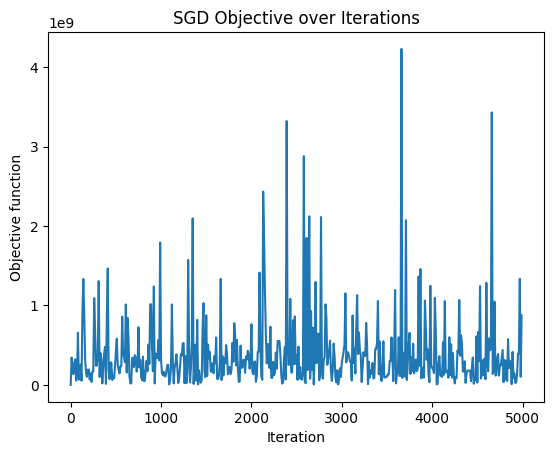

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import numpy as np

# Assuming 'dataset' is the DataFrame loaded from OpenML as before
# Let's assume the target column is named 'class', which we will binarize

# Separate features and target
X = dataset.drop(columns=['class'])
y = dataset['class']

# Convert target to binary labels: for instance, '>50K' to 1 and '<=50K' to -1
y = y.apply(lambda x: 1 if x == '>50K' else -1)

# For simplicity, let's perform one-hot encoding on categorical features
X_encoded = pd.get_dummies(X)

# Convert the DataFrame to NumPy arrays
X_array = X_encoded.values.astype(np.float64)
y_array = y.values.astype(np.float64)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

# Now we can use MySGDLogisticRegression on this data
mlr = MySGDLogisticRegression(gamma=0.05, n_iter=5000, lamb=0, n_batch=1, random_state=42)
mlr.fit(X_train, y_train)
print("Test accuracy:", mlr.score(X_test, y_test))

# Plot the objective function over iterations
import matplotlib.pyplot as plt
obj_list = mlr.obj_list_
iter_list = np.arange(len(obj_list)) * mlr.freq_obj_eval
plt.plot(iter_list, obj_list)
plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.title("SGD Objective over Iterations")
plt.show()

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Question 9 (private SGD) (18 Points)</h2>
</div>

We will now implement and experiment with DP-SGD:
1. Following the model of the function `sgd`, implement a new function `private_sgd` which implements DP-SGD **with mini-batch size of 1 and no regularization**. It can take as input the desired value of $\epsilon$ and $\delta$ for the $(\epsilon,\delta)$-DP, or alternatively the standard deviation of the Gaussian noise to add at each iteration. Note: you do not need to make the objective plotting part private (this is only for monitoring).


2. Following the model of the class `MySGDLogisticRegression`, implement a new class `MyPrivateSGDLogisticRegression` which implements differentially private logistic regression trained using your DP-SGD implementation above.


3. Experiment with different values of $\epsilon$ and $\delta$, number of iterations and step size, and study the effect on the convergence of SGD as well as the test accuracy of the resulting model. Describe your observations. How should the number of iterations depend on the level of privacy? How can we choose the number of iterations and step size in practice?

In [37]:
def private_sgd(X, y, gamma, n_iter, obj_and_grad, theta_init, sigma,
                n_batch=1, freq_obj_eval=10, n_obj_eval=1000, random_state=None):
    """
    Differentially Private SGD with Gaussian noise addition.

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        Step size.
    n_iter : int
        Number of iterations.
    obj_and_grad : callable
        Function that computes objective and gradient.
    theta_init : array, shape (p,)
        Initial parameters.
    sigma : float
        Standard deviation of Gaussian noise added to gradients.
    n_batch : int
        Mini-batch size (should be 1 for DP-SGD as per specification).
    freq_obj_eval : int
        Frequency of objective evaluation.
    n_obj_eval : int
        Number of points used for objective evaluation.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    theta : array, shape=(p,)
        Final model parameters.
    obj_list : list
        List of objective values recorded during training.
    """
    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]

    theta = theta_init.copy()

    # Wrap gamma if it's not callable
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    obj_list = []
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)

        # For DP-SGD, we enforce n_batch = 1 as specified.
        # Sample one data point
        idx = rng.randint(0, n)
        X_batch = X[idx:idx+1, :]
        y_batch = y[idx:idx+1]

        # Compute gradient on the single data point
        _, grad = obj_and_grad(theta, X_batch, y_batch)

        # Add Gaussian noise to the gradient
        noise = rng.normal(loc=0.0, scale=sigma, size=grad.shape)
        noisy_grad = grad + noise

        # Update step size
        step_size = gamma_func(t)

        # Parameter update
        theta -= step_size * noisy_grad

    return theta, obj_list

In [38]:
class MyPrivateSGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Sklearn estimator for logistic regression using differentially private SGD.
    
    Parameters
    ----------
    gamma : float | callable
        Step size.
    n_iter : int
        Number of iterations.
    sigma : float
        Standard deviation of the Gaussian noise for DP.
    n_batch : int
        Mini-batch size (should be 1 for DP-SGD).
    freq_obj_eval : int
        Frequency of objective evaluation.
    n_obj_eval : int
        Number of points for objective evaluation.
    random_state : int
        Random seed.
    """
    
    def __init__(self, gamma, n_iter, sigma, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, random_state=None):
        self.gamma = gamma
        self.n_iter = n_iter
        self.sigma = sigma
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state
    
    def fit(self, X, y):
        # Validate and preprocess X, y as before
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)
                
        p = X.shape[1]
        theta_init = np.zeros(p+1)  # initialize parameters to zero
        
        # Define the objective and gradient function with regularization lambda = 0
        obj_grad = lambda theta, X_batch, y_batch: my_logistic_obj_and_grad(theta, X_batch, y_batch, lamb=0)
        
        # Call private_sgd instead of sgd
        theta, obj_list = private_sgd(
            X, y, self.gamma, self.n_iter, obj_grad, theta_init, self.sigma,
            n_batch=self.n_batch, freq_obj_eval=self.freq_obj_eval,
            n_obj_eval=self.n_obj_eval, random_state=self.random_state
        )
        
        # Save the learned model
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)
        self.obj_list_ = obj_list
        
        return self

Private Test accuracy: 0.7758214760978606


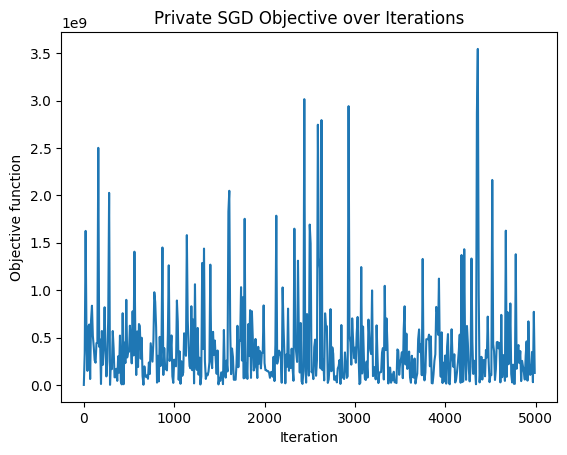

In [39]:
# Example parameters (you would adjust these based on your privacy/utility trade-offs)
gamma = 0.05
n_iter = 5000
sigma = 1.0  # Example noise level, should be set based on desired (ε, δ)
n_batch = 1
random_state = 42

private_lr = MyPrivateSGDLogisticRegression(gamma=gamma, n_iter=n_iter, sigma=sigma,
                                            n_batch=n_batch, random_state=random_state)
private_lr.fit(X_train, y_train)
print("Private Test accuracy:", private_lr.score(X_test, y_test))

# Plot objective function trajectory
plt.plot(np.arange(len(private_lr.obj_list_)) * private_lr.freq_obj_eval, private_lr.obj_list_)
plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.title("Private SGD Objective over Iterations")
plt.show()

<div style="text-align: font-family: 'Arial', sans-serif;">
    <h2 style="color: #2c3e50;">Optional: Question 10 (federated learning with DP: DP-SGD in the distributed model) (20 Points)</h2>
</div>

Enough with these simple queries! Let's train a machine learning model in the federated learning, in which $n$ participants with their own datasets collaborate to train a joint model. Each participant $i$ wants to ensure that the algorithm satisfies $(\epsilon,\delta)$-DP with respect to his/her own dataset $D_i$. This is sometimes referred to as the distributed model of DP. Note that if each participant has a dataset of size 1 then this is exactly local DP. However, the privacy-utility trade-off will be better when participants have more data points, which is what we consider below.

The following code loads the US Census dataset in one-hot encoded version. Feel free to use another binary classification dataset of your choice instead.

In [40]:
X, y = fetch_openml(name='a9a', version=1, return_X_y=True, as_frame=False)
normalizer = Normalizer()
X = normalizer.transform(X)
m, d = X.shape
print(m, d)

48842 123


Consider a setting with $n=5$ participants. To simulate the federated learning setting, we will split the dataset in $n$ local datasets of roughly equal size. To do this, we use `sklearn.model_selection.KFold`.

In [41]:
n = 5
features = {}
labels = {}
for i, idx in enumerate(KFold(n_splits=n, shuffle=True).split(X)):
    features[i] = X[idx[1],:]
    labels[i] = y[idx[1]]
    
for i in range(n):
    print("Dataset of participant " + str(i) + ":", features[i].shape, labels[i].shape)

Dataset of participant 0: (9769, 123) (9769,)
Dataset of participant 1: (9769, 123) (9769,)
Dataset of participant 2: (9768, 123) (9768,)
Dataset of participant 3: (9768, 123) (9768,)
Dataset of participant 4: (9768, 123) (9768,)


We would now like to train a logistic regression classifier with DP-SGD in the federated setting. For simplicity of exposition, assume the presence of an *untrusted* aggregator. The algorithm follows an interative process, where each iteration consists of the following steps:
1. The trusted aggregator sends the current parameters of the model to the participants.

2. Each participant $i$ computes a stochastic gradient using a mini-batch from his local dataset $D_i$, adds Gaussian noise locally to ensure DP, and sends it to the untrusted aggregator.

3. The untrusted aggregator averages these gradients and use the result to update the model with a gradient step.

How much Gaussian noise should each participant add at each iteration to ensure an $(\epsilon,\delta)$-DP guarantee for the entire algorithm?

Adapt your centralized DP-SGD code from the previous practical to simulate this federated learning version. Compare the utility with the centralized version, studying in particular the effect of the number of participants.

Suppose that the local dataset sizes are imbalanced across participants. How does this affect the Gaussian noise added by each participant? How does this effect the utility? Suggest an appropriate weighted aggregation scheme to mitigate this.

### Adapting DP-SGD to Federated Learning

This question explores adapting DP-SGD to a federated learning setting where multiple participants collaboratively train a model while preserving each participant’s differential privacy. We’ll discuss:

---

#### 1. Gaussian Noise per Participant for Given (\(\epsilon, \delta\)):

Each participant must add noise to their computed gradient to ensure their own dataset remains private. The required noise level depends on:

- The sensitivity of the gradient computation for an individual update.
- The desired privacy parameters (\(\epsilon, \delta\)).
- The composition of multiple iterations over which privacy loss accumulates.

In a federated setting with \(n\) participants, the overall algorithm’s privacy can be maintained if each participant ensures \((\epsilon, \delta)\)-DP on their contributions for each iteration. The exact amount of noise each participant should add depends on advanced privacy accounting (e.g., moments accountant or RDP) given the number of iterations and composition.

**A simplified approach:**

- Compute the sensitivity of the gradient for a single data point.
- Use the Gaussian mechanism to add noise \( \mathcal{N}(0, \sigma^2 I) \), where:

  $$
  \sigma = \frac{s_2 \sqrt{2 \ln(1.25/\delta)}}{\epsilon}
  $$

  with \(s_2\) being the \(L_2\)-sensitivity for one participant’s gradient at that iteration. This noise level ensures each participant’s update is \((\epsilon, \delta)\)-DP.

However, in federated learning, the noise scales and composition become more complex due to multiple rounds and aggregation. One would typically use privacy accounting methods to determine per-iteration noise.

---

#### 2. Adapting Centralized DP-SGD to Federated Setting:

**Algorithm Outline for Each Iteration:**

1. **Aggregator to Participants:** Send current model parameters \( \theta_t \) to all participants.
2. **Local Computation (at each participant \(i\)):**
   - Sample a mini-batch from \( D_i \) (in our simplified simulation, we might use the entire local dataset or a batch of size 1).
   - Compute the gradient \( g_i(\theta_t) \) on the mini-batch.
   - Add Gaussian noise: 

     $$
     \tilde{g}_i = g_i(\theta_t) + \mathcal{N}(0, \sigma^2 I)
     $$

   - Send the noisy gradient \( \tilde{g}_i \) to the aggregator.
3. **Aggregator:**
   - Average the received gradients:

     $$
     \bar{g} = \frac{1}{n} \sum_{i=1}^n \tilde{g}_i
     $$

   - Update the model:

     $$
     \theta_{t+1} = \theta_t - \gamma_t \bar{g}
     $$

### Code Sketch for Federated DP-SGD Simulation:

In [42]:
def federated_dp_sgd(participant_features, participant_labels, gamma, n_iter, 
                     obj_and_grad, theta_init, sigma, freq_obj_eval=10, 
                     n_obj_eval=1000, random_state=None):
    """
    Simulates federated DP-SGD with n participants.
    
    Parameters similar to private_sgd, but operates over multiple participants.
    participant_features: dict of feature arrays for each participant.
    participant_labels: dict of label arrays for each participant.
    Other parameters: as defined before.
    
    Returns:
        theta: final model parameters.
        obj_list: list of objective values recorded during training.
    """
    rng = np.random.RandomState(random_state)
    n_participants = len(participant_features)
    # Assume all participants share same feature dimension for simplicity
    p = theta_init.shape[0]
    
    theta = theta_init.copy()
    obj_list = []
    
    # Preselect evaluation indices for objective computation using central dataset (if available)
    # For simulation, we might use data from participant 0 for objective evaluation
    X_eval = participant_features[0]
    y_eval = participant_labels[0]
    n_eval = X_eval.shape[0]
    idx_eval = rng.randint(0, n_eval, n_obj_eval)
    
    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            obj, _ = obj_and_grad(theta, X_eval[idx_eval, :], y_eval[idx_eval])
            obj_list.append(obj)
        
        # Each participant computes a noisy gradient
        gradients = []
        for i in range(n_participants):
            X_i = participant_features[i]
            y_i = participant_labels[i]
            
            # Sample a single data point for mini-batch size 1
            idx = rng.randint(0, X_i.shape[0])
            X_batch = X_i[idx:idx+1, :]
            y_batch = y_i[idx:idx+1]
            
            _, grad = obj_and_grad(theta, X_batch, y_batch)
            noise = rng.normal(loc=0.0, scale=sigma, size=grad.shape)
            noisy_grad = grad + noise
            gradients.append(noisy_grad)
        
        # Aggregator averages the gradients
        avg_grad = np.mean(gradients, axis=0)
        step_size = gamma(t) if callable(gamma) else gamma
        theta -= step_size * avg_grad
    
    return theta, obj_list

### Notes on Code:

- `participant_features` and `participant_labels` are dictionaries holding each participant’s local dataset.
- At each iteration, each participant computes a noisy gradient and sends it to the aggregator.
- The aggregator averages these gradients and performs a model update.

---

### 3. Effect of Number of Participants and Imbalanced Data:

#### Number of Participants:
- With more participants, each individual’s contribution to the average gradient is smaller, which can allow for lower noise levels while maintaining overall privacy.
- More participants generally improve the utility of the aggregated model because noise averages out over more contributions.

#### Imbalanced Local Dataset Sizes:
- If participants have imbalanced data sizes, participants with smaller datasets would have higher sensitivity (because \( s \propto \frac{1}{|D_i|} \)) and may need to add more noise, reducing their contribution’s accuracy.
- Meanwhile, participants with larger datasets could add less noise.

**Weighted Aggregation Scheme:**
To mitigate this, the aggregator can perform a weighted average of gradients, where each participant’s gradient is weighted by the size of their local dataset \( |D_i| \):

$$
\bar{g} = \frac{\sum_{i=1}^n |D_i| \tilde{g}_i}{\sum_{i=1}^n |D_i|}
$$

This gives more influence to participants with more data (who can produce more accurate gradients with less noise relative to their data size), improving overall utility.

---

### Adjusting the Noise Levels:
- Each participant can adjust their noise scale based on their own dataset size:
  - **Larger datasets → lower noise.**
  - **Smaller datasets → higher noise.**